In [207]:
# For data manipulation
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [208]:
# Load the dataset into a DataFrame and save in a variable
df0 = pd.read_csv("datasets/listings.csv")

In [209]:
# Display the first 10 rows of the data
#df0.head(10)

In [210]:
# Gather basic information about the dataset
#df0.info()

In [211]:
# Gather descriptive statistics about the data
#df0.describe()

In [212]:
# Display the size of the dataframe
#df0.shape

In [213]:
# Cast our data to the appropriate types for the contained values
# convert ('host_since', 'first_review', 'last_review') to datetime
df0['host_since'] = pd.to_datetime(df0['host_since'])
df0['first_review'] = pd.to_datetime(df0['first_review'])
df0['last_review'] = pd.to_datetime(df0['last_review'])
# convert ('price') to numeric
df0['price'] = df0['price'].replace(
    {r'\$': '', ',': ''}, regex=True)
df0['price'] = pd.to_numeric(df0['price'])
#df0.info()

In [214]:
# Add derived columns to represent our datetime values as "days since" integers assuming the current date is 2025-10-31
df0['days_on_platform'] = (pd.to_datetime('2025-10-31') - df0['host_since']).dt.days
df0['days_since_last_review'] = (pd.to_datetime('2025-10-31') - df0['last_review']).dt.days
df0['days_since_first_review'] = (pd.to_datetime('2025-10-31') - df0['first_review']).dt.days
#df0.info()

In [248]:
# Add derived categorical column to directly capture whether a listing has previously been reviewed
df0['ever_reviewed'] = df0['number_of_reviews'].notna().astype(int)

In [249]:
# For dropping columns if we don't need them for our analysis
df1 = df0.drop(['host_since', 'last_review', 'first_review', 'scrape_id', 'host_location', 'neighbourhood', 'calendar_updated', 'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude', 'listing_url', 'id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'property_type', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_last_scraped', 'host_has_profile_pic', 'host_verifications', 'beds', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'bathrooms_text'], axis=1)
#df1.info()
#df1.head()

In [250]:
# Drop rows that have missing values in one of these columns
df2 = df1.dropna(axis=0, how='any', subset=['estimated_revenue_l365d', 'price', 'bedrooms', 'bathrooms', 'host_listings_count', 'host_listings_count'], inplace=False, ignore_index=False)
#df2.info()

In [251]:
# Encode categorical columns using pd.Categorical
# This should automatically convert any NaN values to '-1'

# List of categorical columns to encode
categorical_columns = ['license', 'has_availability', 'host_is_superhost', 'instant_bookable', 'host_identity_verified']

# Apply pd.Categorical to each column using .loc
for col in categorical_columns:
    df2.loc[:, col] = pd.Categorical(df2[col]).codes

# Force convert all encoded columns to integer type
df2.loc[:, categorical_columns] = df2[categorical_columns].astype('int64')

#df2.info()

In [252]:
# UNCOMMENT to Replace missing values in these columns with '-1'
# This should support some additional analysis but may not be appropriate for all tasks
# To test *just* the relationship between having ever been reviewed, use the derived 'ever_reviewed' column

#columns_to_replace = ['reviews_per_month', 'days_since_last_review', 'days_since_first_review', 'review_scores_value', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating']
#df2.loc[:, columns_to_replace] = df2[columns_to_replace].fillna(-1)

In [253]:
#validate the column and value dropping conversion
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20191 entries, 0 to 36110
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          20191 non-null  object 
 1   description                                   19805 non-null  object 
 2   neighborhood_overview                         10144 non-null  object 
 3   host_is_superhost                             20191 non-null  object 
 4   host_listings_count                           20191 non-null  float64
 5   host_total_listings_count                     20191 non-null  float64
 6   host_identity_verified                        20191 non-null  object 
 7   neighbourhood_cleansed                        20191 non-null  object 
 8   neighbourhood_group_cleansed                  20191 non-null  object 
 9   room_type                                     20191 non-null  obje

In [254]:
#pd.set_option('display.max_rows',None)
#df2.isna().sum()

In [255]:
# define custom function for outlier filtering based on: 
# <value> <= 1.5*IQR 
# OR
# <value> >= 1.5*IQR
# Results in a mask that needs to be applied
# Intent is for this to be independently calculated against the price values for each neighbourhood 
def get_outlier_mask(x, multiplier=1.5):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - multiplier * IQR
    upper_limit = Q3 + multiplier * IQR
    # Return a boolean mask: True for non-outliers, False for outliers
    return (x >= lower_limit) & (x <= upper_limit)

In [256]:
# Create listings dataframe for just whole apartment/houses from Manhattan or Brooklyn
df_apartment = df2.query("room_type == 'Entire home/apt' and neighbourhood_group_cleansed in ('Manhattan','Brooklyn')")
#df_apartment.info()
#Filter out outliers using previously defined IQR criteria in get_outlier_mask function
mask_apartment = df_apartment.groupby('neighbourhood_cleansed')['price'].transform(get_outlier_mask)
df_apartment_filtered = df_apartment[mask_apartment]

In [257]:
# Create listings dataframe for just rooms in shared apartment/houses from Manhattan or Brooklyn
df_room = df2.query("room_type == 'Private room' and neighbourhood_group_cleansed in ('Manhattan','Brooklyn')" )
#df_room.info()
#Filter out outliers using previously defined IQR criteria in get_outlier_mask function
mask_room = df_room.groupby('neighbourhood_cleansed')['price'].transform(get_outlier_mask)
df_room_filtered = df_room[mask_room]
#df_room_filtered.info()

Brooklyn          Axes(0.1,0.15;0.363636x0.75)
Manhattan    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

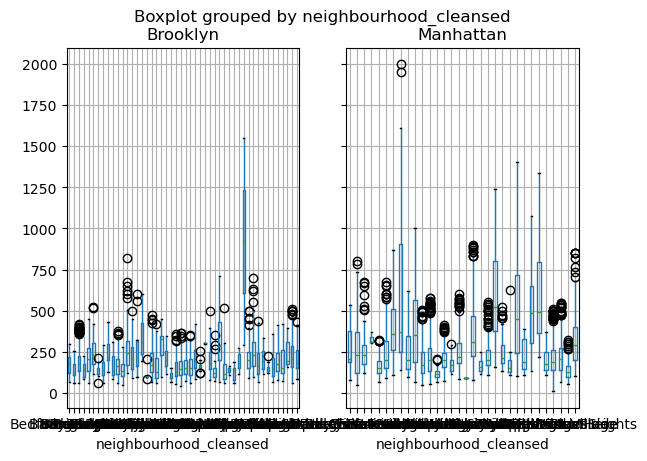

In [260]:
# Exploratory Data Analysis for each feature
#sns.boxplot(
#    x="neighbourhood_cleansed", y="price", data=df_room_brooklyn_cleaned.query("neighbourhood_cleansed == 'Greenpoint'")
#)
#plt.show()
#df_apartment_brooklyn.boxplot(column='price', by='neighbourhood_cleansed') 
#df_room_brooklyn.boxplot(column='price', by='neighbourhood_cleansed')
#df_apartment_manhattan.boxplot(column='price', by='neighbourhood_cleansed') 
#df_room_manhattan.boxplot(column='price', by='neighbourhood_cleansed')
#df_room_filtered.groupby("neighbourhood_group_cleansed").boxplot(column='price', by='neighbourhood_cleansed')
df_apartment_filtered.groupby("neighbourhood_group_cleansed").boxplot(column='price', by='neighbourhood_cleansed')


In [261]:
# Ensure clean DataFrame copies
df_apartment_filtered = df_apartment_filtered.copy()
df_room_filtered = df_room_filtered.copy()

# Add derived columns to apartment df to calculate price per bedroom. 
# To cover the case where studio apartments are listed as bedrooms='0.0' we add a new "private_spaces" column that replaces those 0.0 with 1.0
mask = df_apartment_filtered["bedrooms"] == 0.0
df_apartment_filtered.loc[mask, "private_spaces"] = 1.0
df_apartment_filtered.loc[~mask, "private_spaces"] = df_apartment_filtered.loc[~mask, "bedrooms"]
df_apartment_filtered.loc[:, "price_per_private_space"] = (
    df_apartment_filtered["price"] / df_apartment_filtered["private_spaces"]
)

# Add derived column to apartment and room df to calculate price per per person (based on listed "accomodates" value 
df_apartment_filtered.loc[:, "price_per_person"] = (
    df_apartment_filtered["price"] / df_apartment_filtered["accommodates"]
)
df_room_filtered.loc[:, "price_per_person"] = (
    df_room_filtered["price"] / df_room_filtered["accommodates"]
)

#df_room_filtered.groupby("neighbourhood_group_cleansed").head()
df_room_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5926 entries, 4 to 36100
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          5926 non-null   object 
 1   description                                   5815 non-null   object 
 2   neighborhood_overview                         2719 non-null   object 
 3   host_is_superhost                             5926 non-null   object 
 4   host_listings_count                           5926 non-null   float64
 5   host_total_listings_count                     5926 non-null   float64
 6   host_identity_verified                        5926 non-null   object 
 7   neighbourhood_cleansed                        5926 non-null   object 
 8   neighbourhood_group_cleansed                  5926 non-null   object 
 9   room_type                                     5926 non-null   objec